# 0) Imports & dataset loading

In [1]:
use_google_colab = True
if use_google_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd "/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject"

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import euclidean_distances
from time import time
from tqdm import tqdm
from logger import logger, StatisticalLogger
from sys import getsizeof

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Scientific Computing Tools for Advanced Mathematical Modeling/FinalProject


Dataset Loading

In [2]:
print("loading the dataset")
df_og = pd.read_csv('LAsignals.csv')
# remove index column
df_og = df_og.iloc[:,-len(df_og.columns.values)+1:]
# tidy the dataset
signals = df_og.iloc[:,6:].values
coordinates = df_og.iloc[:,:3]
coordinates = coordinates.values.astype('<f4')
IIR = df_og.iloc[:,5].values.astype('<f2')

loading the dataset


Dimensionality reduction

In [3]:
dataset = np.zeros((coordinates.shape[0],10))
dataset[:,0] = np.max(signals, axis = 1) #max amplitude of the signal
dataset[:,1] = np.min(signals, axis = 1) #min amplitude of the signal
dataset[:,2] = np.var(signals, axis = 1) #variance of the signal
dataset[:,3] = np.max(np.diff(signals), axis = 1) #max amplitude derivative of the signal
dataset[:,4] = np.min(np.diff(signals), axis = 1) #min amplitude derivative of the signal
dataset[:,5] = np.argmax(signals, axis = 1) #position max amplitude peak 
dataset[:,6] = np.argmin(signals, axis = 1) #position min amplitude peak
dataset[:,7] = IIR 
dataset[:,8] = stats.kurtosis(signals, axis = 1)
dataset[:,9] = stats.skew(signals, axis = 1)

data = pd.DataFrame(dataset, columns=["max_ampl", "min_ampl", "var", "max_ampl_der", "min_ampl_der", "position_max", "position_min", "IIR", "kurtosis", "skewness"])
data.info()
# Check if there are None or Null values

col = ["Abnormal"]*coordinates.shape[0]
col = np.array(col)
col[IIR <=1.22] = "Normal"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145134 entries, 0 to 145133
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   max_ampl      145134 non-null  float64
 1   min_ampl      145134 non-null  float64
 2   var           145134 non-null  float64
 3   max_ampl_der  145134 non-null  float64
 4   min_ampl_der  145134 non-null  float64
 5   position_max  145134 non-null  float64
 6   position_min  145134 non-null  float64
 7   IIR           145134 non-null  float64
 8   kurtosis      145134 non-null  float64
 9   skewness      145134 non-null  float64
dtypes: float64(10)
memory usage: 11.1 MB


# 1) Algorithm

The Algorithm works with the assumption of *sparse anomalies*: we suppose that the anomalies are isolated and surrounded by normal signals. 

The Algorithms has the following steps:


1.   Choose randomly *n* signals from the dataset. These signals are denoted as *nuclei*.
2.   For each signal of the dataset find the *nearest* nucleus in terms of Euclidean distance of the coordinates.
3.   For each nucleus compute the means and standard deviations of each variable within the group. Compute then the mahalanobis distance of each signal's features from the mean of the group
4.   Classify as anomaly the *furthest* signals




the hyperparameters are:
*  *n*: stands for the number of randomly sampled points at each iteration
*  *B*: number of iterations
*  *seed*: random seed for reproducibility of the code

In [4]:
def model(n, B, logger, seed = 0):
  print("Running with n = " + str(n) + ", B = " +str(B) + " and seed = " + str(seed))

  random.seed(seed)
  t0 = time()
  delta =1e-7

  final_dataset = np.zeros((coordinates.shape[0],4))

  final_dataset[:,0] = np.abs(data.max_ampl.values - data.min_ampl.values)
  final_dataset[:,1] = np.abs(data.max_ampl_der.values - data.min_ampl_der.values)
  final_dataset[:,2] = np.abs(data.position_max.values - data.position_min.values)
  final_dataset[:,3] = data.iloc[:,-2].values

  classification_matrix = np.zeros((coordinates.shape[0], 1)).astype('<i2')
  idx = np.arange(coordinates.shape[0])

  for b in tqdm(range(B)):
    t1 = time()
    #extract randomly the nuclei
    nuclei_indices = np.array(random.sample(list(np.arange(coordinates.shape[0])), n))
    nuclei_coordinates = np.zeros((n, coordinates.shape[1])) # each row is supposed to be the nucleus
    nuclei_coordinates = coordinates[nuclei_indices, :]
    #we need to find the closest nucleus to each signal
    distances= euclidean_distances(coordinates, nuclei_coordinates)
    logger.write("distance_matrix_size" + " " + str(getsizeof(distances)/1000000000))
    min_index = np.argmin(distances, axis = 1) 
    del distances

    for i in range(n):
      #for each group
      group_idx = idx[min_index == i]
      group_dimension = group_idx.shape[0]

      #1) compute the following statistics within the group
      m = np.mean(final_dataset[group_idx,:], axis = 0) # mean values of the region
      cov = np.cov((final_dataset[group_idx,:] - m).T) #cov of the region

      #2) compute the Mahalanobis distance of each score to the respective mean value (not for the skewness)
      scores = np.zeros((group_dimension, 4))
      scores[:,0] = (final_dataset[group_idx,0] - m[0]) / (np.sqrt(cov[0,0])+delta) * (final_dataset[group_idx,0] - m[0])
      scores[:,1] = (final_dataset[group_idx,1] - m[1]) / (np.sqrt(cov[1,1])+delta) * (final_dataset[group_idx,1] - m[1])
      scores[:,2] = (final_dataset[group_idx,2] - m[2]) / (np.sqrt(cov[2,2])+delta) * (final_dataset[group_idx,2] - m[2])
      scores[:,3] = (final_dataset[group_idx,3] - m[3]) / (np.sqrt(cov[3,3])+delta) * (final_dataset[group_idx,3] - m[3])

      #3) classify as anomalies the farest points 
      thr = np.zeros((4,))
      thr[0] = np.quantile(scores[:,0], q = 0.9)
      thr[1] = np.quantile(scores[:,1], q = 0.9)
      thr[2] = np.quantile(scores[:,2], q = 0.9)
      thr[3] = np.quantile(scores[:,3], q = 0.9)
      anomalies = ((scores[:,0] > thr[0]) + (scores[:,1] > thr[1]) + (scores[:,2] > thr[2]) + (scores[:,3] > thr[3]))
      #4) update the classification matrix
      classification_matrix[group_idx[anomalies.reshape(-1)]] += 1   

    p1 = classification_matrix / (b+1)
    p0 = 1 - p1
    v0 = np.zeros((coordinates.shape[0], 1))
    v1 = np.zeros((coordinates.shape[0], 1))
    v0[p0 != 0] = p0[p0 != 0] * np.log(p0[p0 != 0])
    v1[p1 != 0] = p1[p1 != 0] * np.log(p1[p1 != 0])
    average_normalized_entropy = - np.sum(( v0 + v1 )) / (np.log(2) * coordinates.shape[0])
    logger.write("iteration_time" + " " + str(time() - t1))
    logger.write("random_seed" + " " + str(seed))
    logger.write("average_normalized_entropy" + " " + str(average_normalized_entropy))
    logger.write("number_of_nuclei" + " " + str(n))
    logger.write("num_of_iterations" + " " + str(B))
    del p0, p1, v0, v1, average_normalized_entropy


  #compute the average normalized entropy
  p1 = classification_matrix / (B+1)
  p0 = 1 - p1
  v0 = np.zeros((coordinates.shape[0], 1))
  v1 = np.zeros((coordinates.shape[0], 1))
  v0[p0 != 0] = p0[p0 != 0] * np.log(p0[p0 != 0])
  v1[p1 != 0] = p1[p1 != 0] * np.log(p1[p1 != 0])
  average_normalized_entropy = - np.sum(( v0 + v1 )) / (np.log(2) * coordinates.shape[0])
  del p0, p1, v0, v1
  print("average_normalized_entropy is", average_normalized_entropy)
  print("Time elapsed: " + str(time()-t0))
  print("-*-*-*-*-*-")
  
  return classification_matrix


In [5]:
attempts = [10, 20, 30, 40]
B = 100
seed = [0, 1, 2, 3]

classification_matrix = []
loggers = []
for i, n in enumerate(attempts):
  logger = StatisticalLogger(os.path.join(os.getcwd(), "stat_logs"), "log.txt", encoding = ["iteration_time", "random_seed", "average_normalized_entropy", "distance_matrix_size", "number_of_nuclei", "num_of_iterations"])
  classification_matrix.append(model(n, B, logger, seed[i]))
  loggers.append(logger)


Running with n = 10, B = 100 and seed = 0


100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


average_normalized_entropy is 0.24061452604664904
Time elapsed: 11.505245447158813
-*-*-*-*-*-
Running with n = 20, B = 100 and seed = 1


100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


average_normalized_entropy is 0.31944444926723287
Time elapsed: 14.562149286270142
-*-*-*-*-*-
Running with n = 30, B = 100 and seed = 2


100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


average_normalized_entropy is 0.35174514211772523
Time elapsed: 16.095569610595703
-*-*-*-*-*-
Running with n = 40, B = 100 and seed = 3


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]

average_normalized_entropy is 0.3693938720243584
Time elapsed: 18.00346827507019
-*-*-*-*-*-


# 2) Results

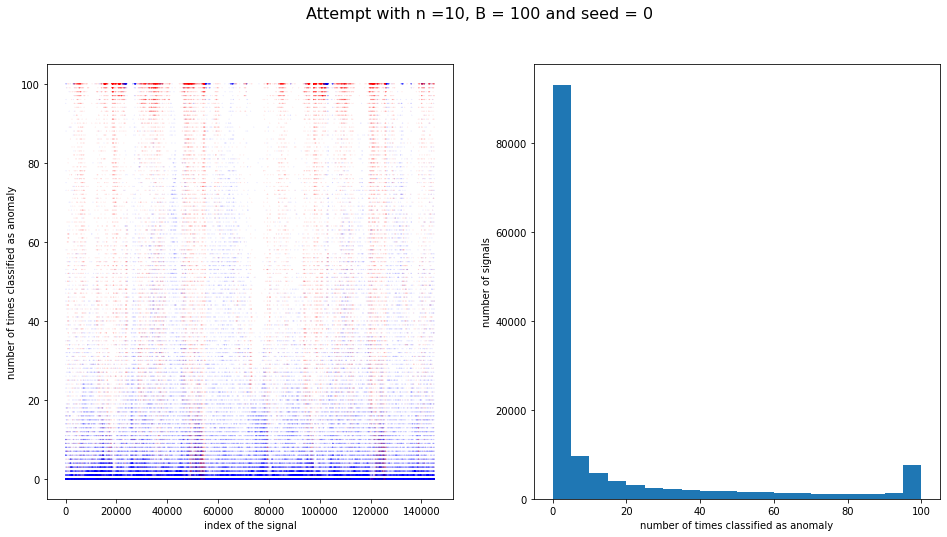

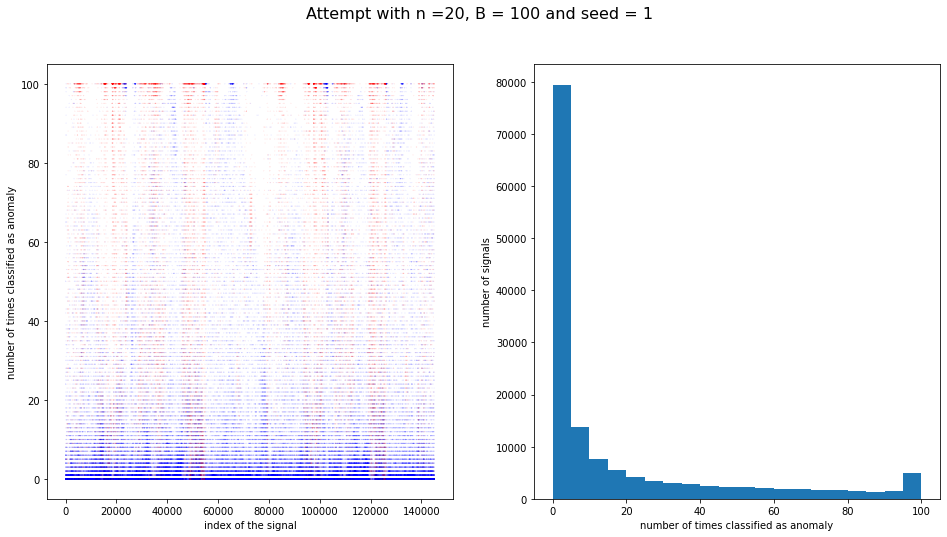

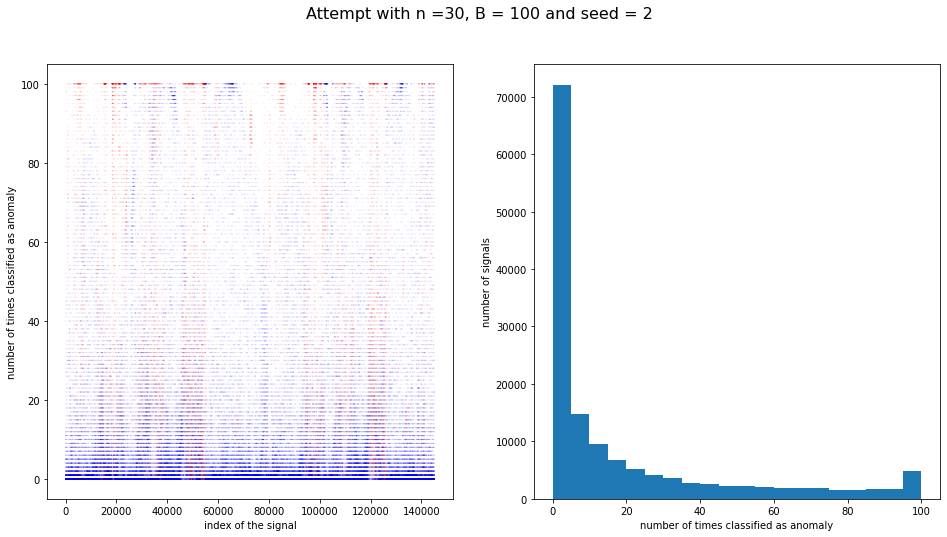

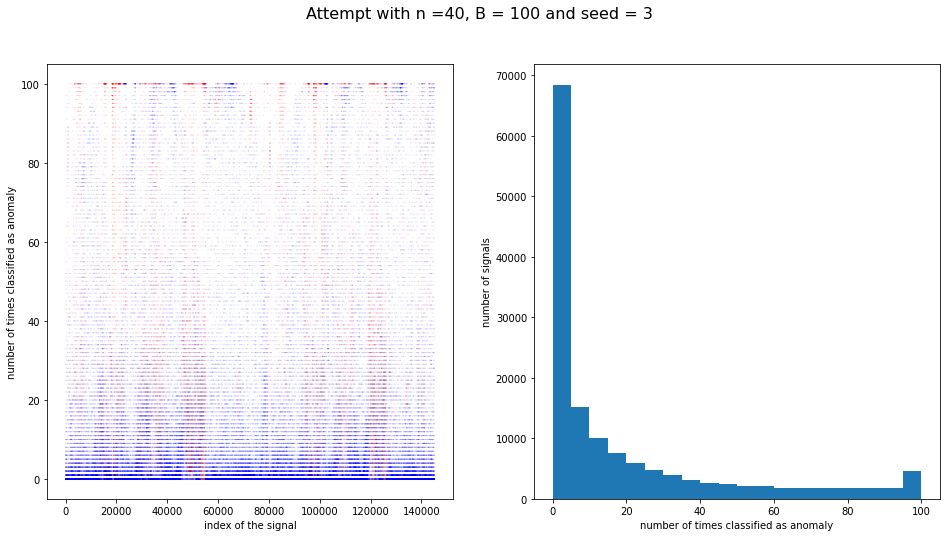

In [6]:
col = ["blue"]*coordinates.shape[0]
col = np.array(col)
col[IIR>1.22] = "red"
for i in range(len(attempts)):
  n = attempts[i]
  fig, ax = plt.subplots(1,2, figsize=(16, 8))
  fig.suptitle("Attempt with n =" + str(n) + ", B = " +str(B) + " and seed = " + str(seed[i]), fontsize=16)

  ax[0].scatter(np.arange(classification_matrix[i].shape[0]),classification_matrix[i].reshape(-1,), s = 0.001, c = col)
  ax[0].set_xlabel("index of the signal")
  ax[0].set_ylabel("number of times classified as anomaly")


  ax[1].hist(classification_matrix[i].reshape(-1,), bins = int(20))
  ax[1].set_xlabel("number of times classified as anomaly")
  ax[1].set_ylabel("number of signals")


Let's find the optimal threshold which minimizes the errors

Optimal Threshold: 25
Optimal Threshold: 27
Optimal Threshold: 30
Optimal Threshold: 26


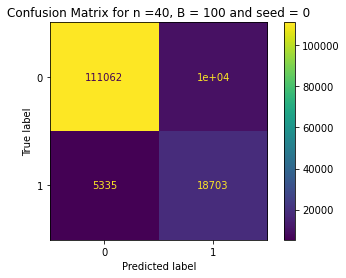

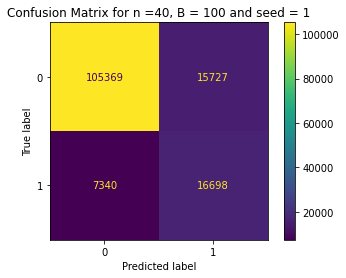

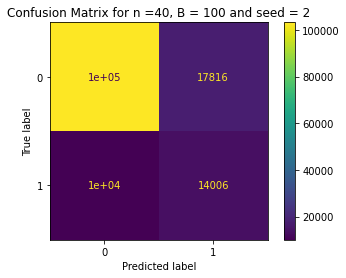

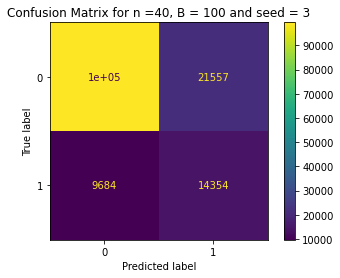

In [7]:
for i in range(len(attempts)): 
  final_labels = np.zeros(classification_matrix[i].shape)
  true_labels = np.zeros(classification_matrix[i].shape)
  true_labels[IIR>1.22] = 1
  val = np.zeros((B,1))

  for thr in range(B):
    final_labels = np.zeros(classification_matrix[i].shape)
    final_labels[classification_matrix[i]>thr] = 1
    value_function = np.sum((final_labels == 1)*(true_labels == 1)) + 0.5* np.sum((final_labels == 0)*(true_labels == 0))
    val[thr, 0] = value_function


  final_labels = np.zeros(classification_matrix[i].shape)
  final_labels[classification_matrix[i]>np.argmax(val)] = 1
  print("Optimal Threshold: " + str(np.argmax(val[:,0])))


  m =confusion_matrix(true_labels, final_labels)
  disp = ConfusionMatrixDisplay(m)
  disp.plot()
  disp.ax_.set_title("Confusion Matrix for n =" + str(n) + ", B = " +str(B) + " and seed = " + str(seed[i]))


# 3) Save the results

In [8]:
for i, logger in enumerate(loggers):
    np.save(logger.get_directory() + os.sep + "classification_matrix", classification_matrix[i])